In [2]:
import torch
torch.cuda.empty_cache()
from dentsegdataset import *

In [3]:
#Training from a saved model
#Specify run used to create original model to continue training
kw_dict = {
    'epochs':20,
    'load_model':True,
    'eval':True,
    'full_model':True,
    'flat':False,
    #'model_name':'ckpt',
    'dataset_path':'/dentseg/app/dataset',
    'image_size':128,
    'lossfunc':'IOU',
    'evalfunc':'IOU',
    'lr':3e-4,
    'in_c':1,
    'out_c':32,
    'layers':5,
    'l0_c':96,
    'run_name':'Dentseg_sa_multi_3', 
    'batch_size':5,
    'sa':True,
    'ghost':False,
    'out_t':'f-mask',
    'proba_model_name':'Dentseg_sa_proba',
}
model, proba_model, output = launch(**kw_dict)


/dentseg/app/dataset/models/Dentseg_sa_proba/ckpt.pth


 16%|█▌        | 3/19 [00:03<00:15,  1.05it/s, Loss=0.47, Acc.=0.997] 

test loss: 0.38741010427474976, accuracy: 0.9981021881103516
test loss: 0.43397146463394165, accuracy: 0.9975357055664062
test loss: 0.47047215700149536, accuracy: 0.9974651336669922


 21%|██        | 4/19 [00:04<00:13,  1.12it/s, Loss=0.346, Acc.=0.998]

test loss: 0.346035897731781, accuracy: 0.9979656219482422


 26%|██▋       | 5/19 [00:05<00:12,  1.14it/s, Loss=0.488, Acc.=0.998]

test loss: 0.48835456371307373, accuracy: 0.9979110717773437


 32%|███▏      | 6/19 [00:06<00:11,  1.16it/s, Loss=0.362, Acc.=0.998]

test loss: 0.3619527816772461, accuracy: 0.9979404449462891


 37%|███▋      | 7/19 [00:06<00:10,  1.16it/s, Loss=0.292, Acc.=0.998]

test loss: 0.292466938495636, accuracy: 0.9982276916503906


 42%|████▏     | 8/19 [00:07<00:09,  1.17it/s, Loss=0.474, Acc.=0.997]

test loss: 0.4742206335067749, accuracy: 0.997341537475586


 47%|████▋     | 9/19 [00:08<00:08,  1.19it/s, Loss=0.472, Acc.=0.997]

test loss: 0.47180086374282837, accuracy: 0.9970966339111328


 53%|█████▎    | 10/19 [00:09<00:07,  1.19it/s, Loss=0.374, Acc.=0.998]

test loss: 0.37432658672332764, accuracy: 0.9982715606689453


 58%|█████▊    | 11/19 [00:10<00:06,  1.18it/s, Loss=0.471, Acc.=0.997]

test loss: 0.4705352187156677, accuracy: 0.9971969604492188


 63%|██████▎   | 12/19 [00:11<00:05,  1.18it/s, Loss=0.315, Acc.=0.999]

test loss: 0.31521034240722656, accuracy: 0.9985729217529297


 68%|██████▊   | 13/19 [00:11<00:05,  1.18it/s, Loss=0.37, Acc.=0.998] 

test loss: 0.3699273467063904, accuracy: 0.9976646423339843


 74%|███████▎  | 14/19 [00:12<00:04,  1.18it/s, Loss=0.385, Acc.=0.998]

test loss: 0.3849690556526184, accuracy: 0.9982757568359375


 79%|███████▉  | 15/19 [00:13<00:03,  1.18it/s, Loss=0.477, Acc.=0.998]

test loss: 0.4774649143218994, accuracy: 0.9978420257568359


 84%|████████▍ | 16/19 [00:14<00:02,  1.18it/s, Loss=0.474, Acc.=0.997]

test loss: 0.4736691117286682, accuracy: 0.9968418121337891


 89%|████████▉ | 17/19 [00:15<00:01,  1.18it/s, Loss=0.365, Acc.=0.998]

test loss: 0.3650420904159546, accuracy: 0.997744369506836


 95%|█████████▍| 18/19 [00:16<00:00,  1.18it/s, Loss=0.463, Acc.=0.997]

test loss: 0.4628748893737793, accuracy: 0.9967845916748047


100%|██████████| 19/19 [00:17<00:00,  1.11it/s, Loss=0.319, Acc.=0.998]

test loss: 0.31935054063796997, accuracy: 0.9982124328613281
mean loss: 0.407371345319246


In [6]:
output, model, proba_model = (model,proba_model,output)
pred = (logistic.cdf(output[3][2][4])>0.5).astype(int)

In [4]:
print(eval_loss)

<class 'pandas.core.series.Series'>


In [5]:
ground = output[3][1][4]

In [6]:
np.sum(pred==ground)/len(pred)

NameError: name 'pred' is not defined

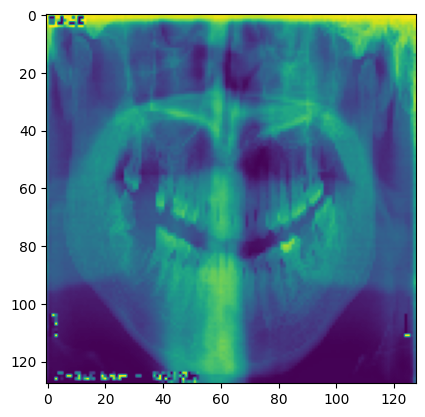

In [7]:
plt.imshow(output[3][0][4][0])

In [10]:
(logistic.cdf(output[15][2][3][20])>0.5).astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

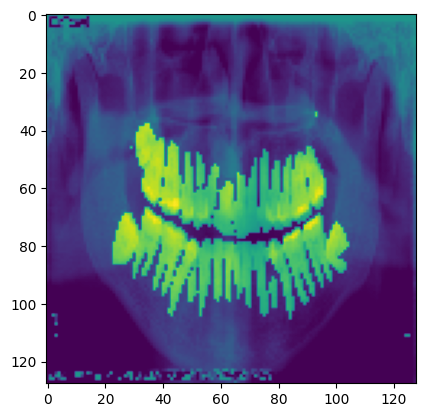

In [3]:
plt.imshow(output[16][0][3][0] + np.sum((logistic.cdf(output[16][2][3])>0.5).astype(int),axis=0).astype(bool))

In [1]:
plt.imshow(np.sum(logistic.cdf(output[16][0][3]),axis=0)>16)

NameError: name 'plt' is not defined

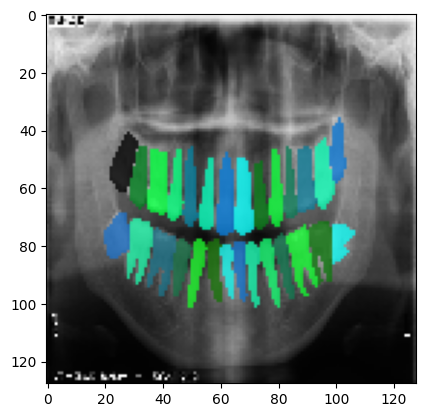

In [7]:
def apply_colored_mask(image, masks, threshold=0.5):
    """
    Applies multiple masks to an image, each in a specified color.
    
    Parameters:
    - image: The original grayscale image.
    - masks: A list of masks to apply.
    - colors: A list of colors corresponding to each mask.
    - threshold: The threshold for applying the masks.
    
    Returns:
    - The image with colored masks applied.
    """
    # Ensure the image is in RGBA to overlay colors
    
    colored_image = cv2.cvtColor(image*255,cv2.COLOR_GRAY2RGB)
    colored_image = torch.tensor(colored_image).detach().cpu().type(torch.uint8).permute(2,0,1)
    seg_mask = torch.tensor(logistic.cdf(masks)>threshold).detach().cpu()
    colored_image = draw_segmentation_masks(colored_image,seg_mask)
    return colored_image.permute(1,2,0).numpy()

test_image = apply_colored_mask(output[0][0][2][0],output[0][1][2])
plt.imshow(test_image)


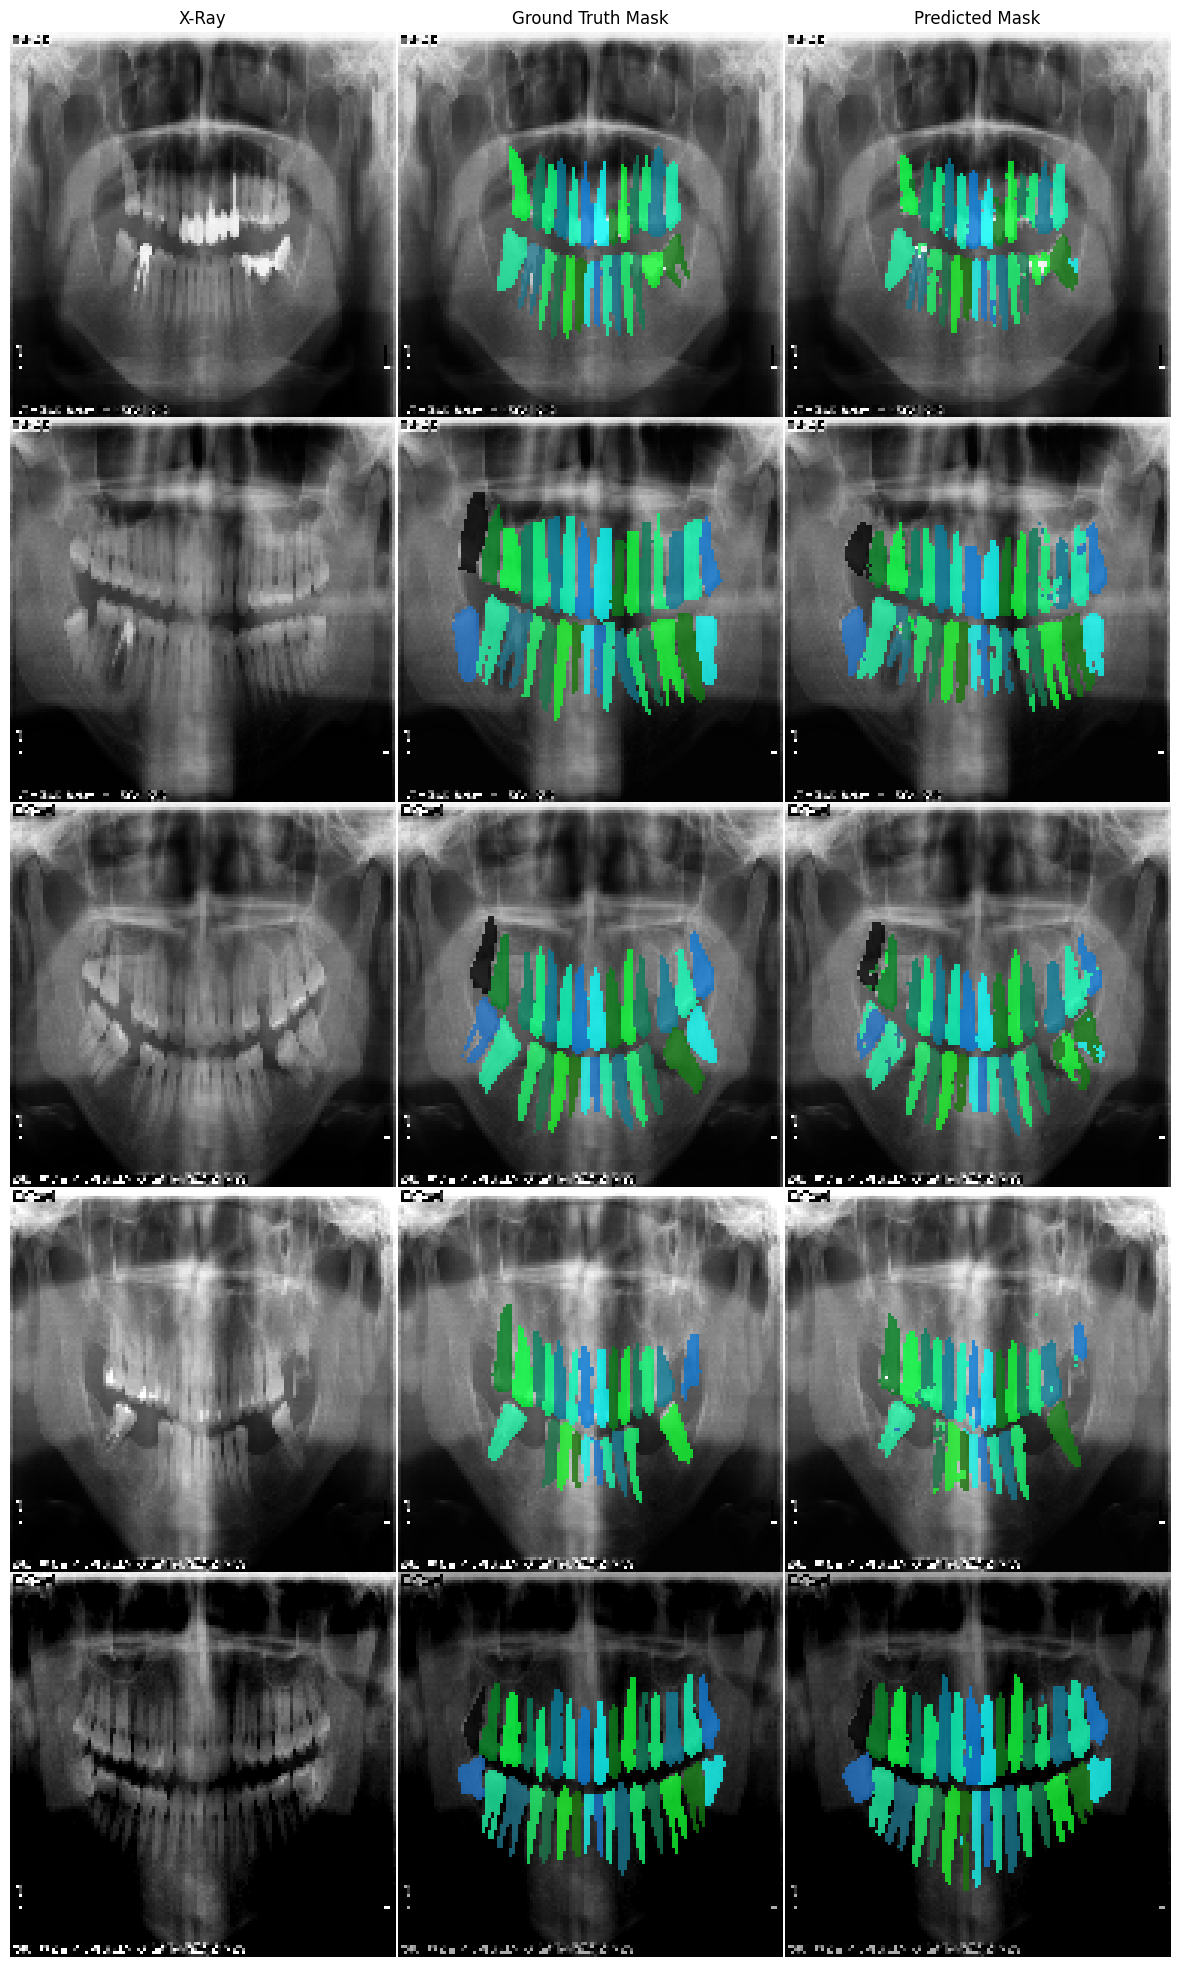

In [14]:
def display_results(data, batch_no:int):
    """
    Displays an X-ray image with ground truth and predicted masks color-coded and overlaid.
    
    Parameters:
    - data: A tuple containing the datasets (X-rays, ground truth masks, predicted masks).
    - batch_no: The index of the image to display.
    """
    
    
    x_ray_images, ground_truth_masks, predicted_masks = data[batch_no]
    num_sets = len(data[0][0])
    fig, axs = plt.subplots(num_sets, 3, figsize=(15, 5*num_sets))
    
    # Remove the gap between images
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for i in range(num_sets):
        # Plot X-Ray
        axs[i, 0].imshow(x_ray_images[i][0], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title('X-Ray' if i == 0 else "")

        # Plot Ground Truth Mask
        axs[i, 1].imshow(apply_colored_mask(x_ray_images[i][0],ground_truth_masks[i]))
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Ground Truth Mask' if i == 0 else "")

        # Plot Predicted Mask
        axs[i, 2].imshow(apply_colored_mask(x_ray_images[i][0],predicted_masks[i]))
        axs[i, 2].axis('off')
        axs[i, 2].set_title('Predicted Mask' if i == 0 else "")
    
    # Show the plot
    plt.show()

display_results(output,6)


In [40]:
torch.tensor(output[0][0][0][0])

tensor([[0.9843, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9882],
        [0.9961, 0.1529, 0.0118,  ..., 0.9804, 0.9725, 0.9882],
        [0.9804, 0.0118, 1.0000,  ..., 0.9176, 0.9333, 0.9294],
        ...,
        [0.0118, 0.7098, 0.0118,  ..., 0.0078, 0.0196, 0.1137],
        [0.0118, 1.0000, 1.0000,  ..., 0.0078, 0.0157, 0.1059],
        [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0157, 0.0941]])

In [6]:
grid = make_grid(torch.tensor(output[0][0][0][0]))
len(grid)
show(list(grid))

NameError: name 'make_grid' is not defined